
# Watershed Dynamics Model 

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:300px;padding:20px">   


<br />
This Jupyter Notebook runs the Landlab LandslideProbability component on a synthetic 
Landlab grid using four recharge options as described in the paper: <br />
#### Strauch et al. 2018. A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6, 1-26. <br /> 
This notebook performs the following functions:<br >
* Import libraries and set HydroShare variables<br />
* Create a grid and data fields used to calculate landslide probability<br />
* Specify Recharge Distributions to compare four options<br /> 
* Run LandslideProbability function from Landlab landslide component<br /> 
* Compare the sensitivity based on four recharge options<br /> 



## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

In [89]:
#import Python utilities for calculating and plotting
import numpy as np
import matplotlib.pyplot as plt

#import Landlab
from landlab import RasterModelGrid
from landlab.components import landslides
from landlab.components.landslides import LandslideProbability
from landlab.plot import imshow_grid
from landlab.io import read_esri_ascii

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## Create a grid and data fields used to calculate landslide probability

This example uses a synthetic model domain. As a first example, make a synthetic grid with 5 rows and 4 columns space 0.2 units apart.   <br /> 
##### Synthetic Grid Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the rows, columns, and spacing of your choice.  

In [90]:
grid = RasterModelGrid((5, 4))

Confirm the size of the grid

In [91]:
grid.number_of_nodes

20

To see what the grid id of our nodes are, execute the command below.  However, note that this command gives you the rows of the grid, but these are technically up-side-down from how the RasterModelGrid nodes are numbered (e.g,. node id 0 is at the bottom left corner of the grid). 

In [92]:
grid.nodes

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])

We can also see how many core nodes we have (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'. Compare this array to the full grid above.  Asign these to the variable 'core_nodes' so we can use these later.

In [93]:
core_nodes = grid.core_nodes
core_nodes

array([ 5,  6,  9, 10, 13, 14])

Check the list of data inputs that the component needs.

In [94]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

Check the list of data outputs that the component will generate.

In [95]:
sorted(LandslideProbability.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__probability_of_saturation']

Review the details of what each variable represents.  Close the window with the upper right [x] after viewing.

In [96]:
?LandslideProbability

Check the details of any input or output variable.

In [97]:
LandslideProbability.var_help('soil__transmissivity')

name: soil__transmissivity
description:
  mode rate of water transmitted through a unit width of saturated
  soil - either provided or calculated with Ksat and soil depth
units: m2/day
at: node
intent: in


Now we will create the required fields for the landslide component and add data as fields to the grid.  Thus, the data arrays will need to be as the length of the number of nodes.<br /> 
##### Data Fields Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the data inputs of your choice.  

In [98]:
gridnodes = grid.number_of_nodes
grid_size = grid.number_of_nodes

grid['node']['soil__density']= \
         2000. * np.ones(gridnodes)

grid['node']['soil__internal_friction_angle']= \
         np.sort(np.random.uniform(26, 37, gridnodes))

grid['node']['soil__mode_total_cohesion']= \
         np.sort(np.random.uniform(30, 900, gridnodes))
    
scatter_dat = np.random.uniform(1, 10, gridnodes)    
grid['node']['soil__maximum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] + scatter_dat

grid['node']['soil__minimum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] - scatter_dat

grid['node']['soil__thickness']= \
         np.sort(np.random.uniform(1, 10, gridnodes))

grid['node']['soil__transmissivity']= \
         np.sort(np.random.uniform(5, 20, gridnodes),-1)

grid['node']['soil__saturated_hydraulic_conductivity']= \
        grid['node']['soil__transmissivity']/grid['node']['soil__thickness']
        
grid['node']['topographic__slope'] = np.random.rand(gridnodes)

grid['node']['topographic__specific_contributing_area']= \
         np.sort(np.random.uniform(30, 900, gridnodes))

Let's see what one of these fields (slope) looks like on the grid.

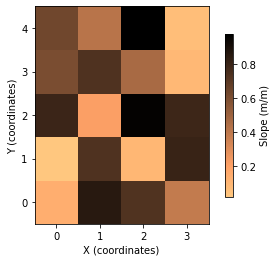

In [99]:
imshow_grid(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')

### Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety values using a Monte Carlo simulation approach, which randomly selects input values from parameter distributions. You can pick the number of iterations to run Monte Carlo simulations, but the default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure result becomes.<br /> 
##### Random iterations Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the number of iterations of your choice.  

In [100]:
n = 25

## Specify Recharge Distributions to compare four options

There are _four_ different options for providing recharge for the Monte Carlo simulation.  We'll provide each of these recharge options below by specifying a recharge distribution and the necessary parameters. <br /> 
##### Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cells below to adjust the recharge distributions.

 ### 0. Recharge Option - component defaults

In [101]:
LS_prob0 = LandslideProbability(grid)
print('Distribution = Uniform for Default') #LS_prob0.groundwater__recharge_distribution)
print('Recharge successfully instantiated with defaults')


Distribution = Uniform for Default
Recharge successfully instantiated with defaults


 ### 1. Recharge Option - 'uniform' distribution 

In this option, we'll apply a uniform distribution of recharge based on minimum and maximum recharge values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and instantiating the component.


In [102]:
distribution1 = 'uniform'
Remin_value = 5 
Remax_value = 15 

LS_prob1 = LandslideProbability(grid,number_of_iterations=n,
    groundwater__recharge_distribution=distribution1,
    groundwater__recharge_min_value=Remin_value,
    groundwater__recharge_max_value=Remax_value)
#print('Distribution = ' + LS_prob1.groundwater__recharge_distribution)
print('Uniform recharge successfully instantiated')

Uniform recharge successfully instantiated


### 2. Recharge Option - 'lognormal' distribution

In this option, we specify a lognormal distribution with a recharge mean and standard deviation values.  We instantiate the LandslideProbabilty class to create a new object or 'instance' of the class/component LandslideProbability. So now we have created two instances.

In [103]:
distribution2 = 'lognormal'
Remean = 10.
Restandard_deviation = 0.25
LS_prob2 = LandslideProbability(grid,number_of_iterations=n,
    groundwater__recharge_distribution=distribution2,
    groundwater__recharge_mean=Remean,
    groundwater__recharge_standard_deviation=Restandard_deviation)
print('Lognormal recharge successfully instantiated')

Lognormal recharge successfully instantiated


### 3. Recharge Option - 'lognormal_spatial' distribution

Similar to the previous option (#2), we use a lognormal distribution for recharge.  However, in this case we provide arrays to represent mean and standard deviation values for each node in our grid.  Thus, the recharge distribution varies for each node - representing a spatially varying distribution of recharge.

In [104]:
distribution3 = 'lognormal_spatial'
Remean3 = np.random.randint(5,15,grid_size)
Restandard_deviation3 = np.random.rand(grid_size)
LS_prob3 = LandslideProbability(grid,number_of_iterations=n,
    groundwater__recharge_distribution=distribution3,
    groundwater__recharge_mean=Remean3,
    groundwater__recharge_standard_deviation=Restandard_deviation3)
#print('Distribution = ' + LS_prob3.groundwater__recharge_distribution)
print('Lognormal spatial recharge successfully instantiated')

Lognormal spatial recharge successfully instantiated


### 4. Recharge Option - 'data_driven_spatial' distribution 

This is the most complex representation of recharge used in the LandslideProbability component.  
In this case, we provide recharge distributions (arrays) directly that are unique for each node.  

In a real-world situation, we would acquire these from a hydrologic model that often has a coarser resolution than our grid.<br />
Thus, we route the recharge data arrays from these larger Hydraulic Source Domain (HSD) grids down to each node of our grid. Landlab has a 'Source tracking algorithm' utility that performs this routing and produces Python dictionaries (_key: value_ pairs) that become parameters for the 'data_driven_spatial' recharge distribution.  In this synthetic example, we'll generate synthetic versions of these dictionaries.

In [105]:
HSD_dict = {}
for vkey in range(2,8):  #the first example vkey =2 is printed below
    HSD_dict[vkey] = np.random.randint(5,15,10)    # 20 - 120 mm/day 
print('HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). ')    
print('The entire synthetic dictionary is:')
print(HSD_dict)
print('The array for the HSD vkey = 2 of this unordered dictionary is:')
print(HSD_dict[2])

HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). 
The entire synthetic dictionary is:
{2: array([10,  5,  8,  8, 12, 14,  8, 10,  7,  9]), 3: array([12, 11, 13, 13,  6, 11, 12, 12, 13,  6]), 4: array([10, 14, 13, 14,  9,  8,  5,  8, 10,  5]), 5: array([ 7,  8, 13,  6,  8,  8,  8, 12,  5,  6]), 6: array([14, 14,  5,  9, 12,  8,  7, 12,  7,  5]), 7: array([ 5,  9, 10, 10, 11, 13,  9,  6,  9, 14])}
The array for the HSD vkey = 2 of this unordered dictionary is:
[10  5  8  8 12 14  8 10  7  9]


HSD_ID dictionary has the grid node ID as ‘keys’ and HSD IDs in a list as ‘values’. 

In [106]:
HSD_id_dict = {}
for ckey in grid.core_nodes:
    HSD_id_dict[ckey] = np.random.randint(2,8,2)
print('The entire ID synthetic dictionary is:')
print(HSD_id_dict)
print('The array for the ckey = 5, the first index of core nodes in the dictionary is:')
print(HSD_id_dict[5])
print('The two values in the array are the multiple vkeys that correspond/drain to the ckey:')


The entire ID synthetic dictionary is:
{5: array([4, 4]), 6: array([2, 3]), 9: array([3, 3]), 10: array([3, 5]), 13: array([5, 4]), 14: array([5, 2])}
The array for the ckey = 5, the first index of core nodes in the dictionary is:
[4 4]
The two values in the array are the multiple vkeys that correspond/drain to the ckey:


The fractions dictionary assigns to each node ID as ‘key’ a lists the fractions of each HSD draining to the node as ‘values’. 

In [107]:
fract_dict = {}
for ckey in grid.core_nodes:
    fract_dict[ckey] =  np.random.rand(2)
print('The entire ID synthetic dictionary is:')
print(fract_dict)
print('The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:')
print(fract_dict[5])

The entire ID synthetic dictionary is:
{5: array([ 0.31542835,  0.36371077]), 6: array([ 0.57019677,  0.43860151]), 9: array([ 0.98837384,  0.10204481]), 10: array([ 0.20887676,  0.16130952]), 13: array([ 0.65310833,  0.2532916 ]), 14: array([ 0.46631077,  0.24442559])}
The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:
[ 0.31542835  0.36371077]


When the component is instantiated, the three dictionaries are provided as the 'parameters' for the distribution in explicit order.

In [108]:
distribution4 = 'data_driven_spatial'
HSD_inputs = [HSD_dict,HSD_id_dict,fract_dict]
LS_prob4 = LandslideProbability(grid,number_of_iterations=n,
    groundwater__recharge_distribution=distribution4,
    groundwater__recharge_HSD_inputs=HSD_inputs)
#print('Distribution = ' + LS_prob4.groundwater__recharge_distribution)
print('Data driven spatial recharge successfully instantiated')

Data driven spatial recharge successfully instantiated


## Run the Landslide Component 

To generate the outputs from running the component, we call the 'calculate_landslide_probability' method inside the component using the class instance (e.g., LS_prob1) for each recharge option specified above. The following cell runs the model; in the following section we will assessing the results.

###  Run the Landslide Component in Default Mode

Uniform recharge; default parameters.

Using recharge defaults (option 0) as an example, run the recharge option simulation of probability of failure. 


In [109]:
LS_prob0.calculate_landslide_probability()
print('Landslide probability successfully calculated')

Landslide probability successfully calculated


The outputs of model simulations are:

In [110]:
sorted(LS_prob0.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__probability_of_saturation']

Save the arrays as variables by 'attaching the fields to the grid' and view the outputs. 

This simulation generates a probability value for each core node. 

In [111]:
LS_prob0_probability_of_failure = grid.at_node['landslide__probability_of_failure']
grid.at_node['landslide__probability_of_failure']

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.   ,  0.992,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ])

This simulation generates a mean relative wetness value for each core node.

In [112]:
LS_prob0_relative_wetness = grid.at_node['soil__mean_relative_wetness']
grid.at_node['soil__mean_relative_wetness']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.99955092,  1.        ,  0.        ,  0.        ,  1.        ,
        0.99967728,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

These model output arrays are attached to the grid as fields. When we run the model for a different recharge, these fields are over-written. 

###  Run the Landslide Component and Save Outputs for Four Different Modes

Run the remaining three recharge options and save the arrays as variables for plotting.

In [113]:
LS_prob1.calculate_landslide_probability()
LS_prob1_probability_of_failure = grid.at_node['landslide__probability_of_failure']
LS_prob1_relative_wetness = grid.at_node['soil__mean_relative_wetness']

LS_prob2.calculate_landslide_probability()
LS_prob2_probability_of_failure = grid.at_node['landslide__probability_of_failure']
LS_prob2_relative_wetness = grid.at_node['soil__mean_relative_wetness']

LS_prob3.calculate_landslide_probability()
LS_prob3_probability_of_failure = grid.at_node['landslide__probability_of_failure']
LS_prob3_relative_wetness = grid.at_node['soil__mean_relative_wetness']

LS_prob4.calculate_landslide_probability()
LS_prob4_probability_of_failure = grid.at_node['landslide__probability_of_failure']
LS_prob4_relative_wetness = grid.at_node['soil__mean_relative_wetness']

## View the  Landslide Outputs with Default Parameters 

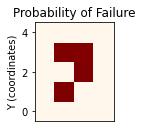

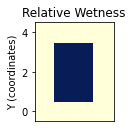

In [114]:
fig = plt.figure('Probability of Failure')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid, LS_prob0_probability_of_failure, plot_name='Probability of Failure',
                    allow_colorbar=False, cmap='OrRd',
                    grid_units=('coordinates',''))

fig = plt.figure('Mean Relative Wetness')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid, LS_prob0_relative_wetness, plot_name='Relative Wetness',
                    allow_colorbar=False, cmap='YlGnBu',
                    grid_units=('coordinates',''))

## Compare the sensitivity based on four recharge options

Now lets do some plotting to see what we produced.  The four commands below will plot the probability of failure for each of the recharge options we specified above.

### Compare the Probability of failure
Now lets compare the probabilities of failure for our four recharge options.  Note - we use the arrays we named above instead of fields after 'grid'.

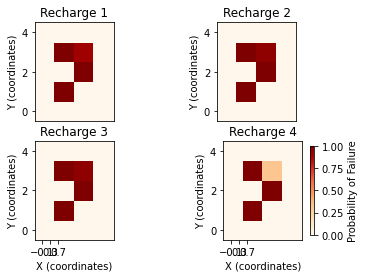

In [115]:
fig = plt.figure('Probability of Failure')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid, LS_prob1_probability_of_failure, plot_name='Recharge 1',
                    allow_colorbar=False, cmap='OrRd',
                    grid_units=('coordinates',''))
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid, LS_prob2_probability_of_failure, plot_name='Recharge 2',
                    allow_colorbar=False, cmap='OrRd',
                    grid_units=('coordinates', 'coordinates'))
ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid(grid, LS_prob3_probability_of_failure,plot_name='Recharge 3',
                    allow_colorbar=False, cmap='OrRd',
                    grid_units=('coordinates', 'coordinates'))
ax4 = fig.add_subplot(224)
ax4.set_xticks(xticks)
imshow_grid(grid, LS_prob4_probability_of_failure, cmap='OrRd', plot_name='Recharge 4',
                    grid_units=('coordinates', 'coordinates'), shrink=0.9,
                    var_name='Probability of Failure')
plt.savefig('Probability_of_Failure_synthetic.png')

Note that only the core nodes in the middle have values.  The outside nodes are closed.  Also, see how these compare with the slope plot above.

Now lets do the same for mean relative wetness.

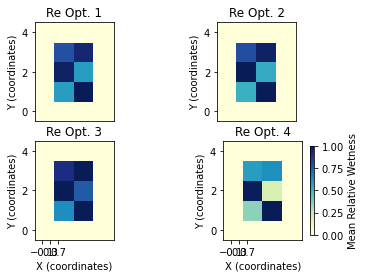

In [116]:
fig = plt.figure('Mean Relative Wetness')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid, LS_prob1_relative_wetness, plot_name='Re Opt. 1',
                    allow_colorbar=False, cmap='YlGnBu',
                    grid_units=('coordinates',''))
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid, LS_prob2_relative_wetness, plot_name='Re Opt. 2',
                    allow_colorbar=False, cmap='YlGnBu',
                    grid_units=('coordinates', 'coordinates'))
ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid(grid, LS_prob3_relative_wetness,plot_name='Re Opt. 3',
                    allow_colorbar=False, cmap='YlGnBu',
                    grid_units=('coordinates', 'coordinates'))
ax4 = fig.add_subplot(224)
ax4.set_xticks(xticks)
imshow_grid(grid, LS_prob4_relative_wetness, cmap='YlGnBu', plot_name='Re Opt. 4',
                    grid_units=('coordinates', 'coordinates'), shrink=0.9,
                    var_name='Mean Relative Wetness')
plt.savefig('Mean_Relative_Wetness_synthetic.png')

These might be all 1.0, which is the maximum, indicating that given the inputs above, this domain is often saturated.